relationship between MSE and r2

https://stats.stackexchange.com/questions/34033/confusion-regarding-correlation-and-mse

https://dsp.stackexchange.com/questions/9491/normalized-square-error-vs-pearson-correlation-as-similarity-measures-of-two-sig

note that these two results are not about the same definition of MSE.

One is about MSE between `X` and `Y`

another is about MSE between `Y` and `Y hat`, which is `a X + b`.

Therefore, their end results do not seem consistent, although they are both correct.

`S^2` means corrected sample variance, and `S` is sqrt of it.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from sys import path
from os.path import relpath, realpath, abspath, join, exists, dirname
from os import makedirs
from itertools import product
from functools import partial
import numpy as np
import pandas as pd

In [3]:
from torchnetjson.builder import build_net

In [4]:
from thesis_v2 import dir_dict
from thesis_v2.data import load_data_helper
from thesis_v2.training.training_aux import load_training_results
from thesis_v2.training_extra.misc import count_params
from thesis_v2.models.maskcnn_polished_with_rcnn_k_bl.builder import load_modules

load_modules()

In [5]:
from thesis_v2.configs.model.maskcnn_polished_with_rcnn_k_bl import (
    explored_models_20200218 as param_iterator_obj,
    keygen
)

In [6]:
from thesis_v2.training_extra.data import generate_datasets
from thesis_v2.training_extra.evaluation import eval_fn_wrapper as eval_fn_wrapper_neural
from thesis_v2.training.training import eval_wrapper
from thesis_v2.data.prepared.yuanyuan_8k import get_data, get_neural_data

In [7]:
from torch.backends import cudnn
import torch
cudnn.enabled = True
cudnn.deterministic = True
cudnn.benchmark = False

_data_cache = dict()

def get_data_cached(input_size, seed):
    if (input_size, seed) not in _data_cache:
        _data_cache[input_size, seed] = get_data('a', 200, input_size,
                                                 ('042318', '043018', '051018'),
                                                 scale=0.5,
                                                 seed=seed)
    return _data_cache[input_size, seed]

In [8]:
# compute ccmax
from strflab.stats import cc_max
from thesis_v2.data.prepared.yuanyuan_8k import get_neural_data_per_trial

cc_max_all_neurons = cc_max(get_neural_data_per_trial(
    ('042318', '043018','051018',))
                           )
assert cc_max_all_neurons.shape == (79,)

In [9]:
from scipy.stats import pearsonr

In [10]:
def calculate_cc(responses, label):
    assert responses.shape == label.shape
    assert responses.ndim == 2
    assert responses.shape[1] == 79

    corr_each = np.array(
        [
            pearsonr(yhat, y)[0] if np.std(yhat) > 1e-5 and np.std(y) > 1e-5 else 0 for yhat, y in zip(responses.T, label.T)
        ]
    )
    assert corr_each.shape == (79,)
    return corr_each

def calculate_cc2(responses, label):
    ret = calculate_cc(responses, label)**2
    assert ret.shape == (79,)
    return ret 

def calculate_mse(responses, label):
    assert responses.shape == label.shape
    assert responses.ndim == 2
    assert responses.shape[1] == 79
    
    mse_each = np.mean((responses-label)**2, axis=0)
    assert mse_each.shape == (79,)
    return mse_each

def normalize(raw_each, power, method):
    assert raw_each.shape == (79,) == cc_max_all_neurons.shape
    assert type(power) is int and power in {1,2}
    assert method in {'div', 'mul'}
    if method == 'div':
        ret = raw_each/(cc_max_all_neurons**power)
    elif method == 'mul':
        # for mse, intuitively, more inheriently noisy neurons (smaller cc_max) should be discounted for its error.
        ret = raw_each*(cc_max_all_neurons**power)
    else:
        raise ValueError

    assert ret.shape == (79,)
    return ret
    
metric_map = {
    'mse': calculate_mse,
    'cc': calculate_cc,
    'cc2': calculate_cc2,
}

norm_power_map = {
    'mse': {
        # intuitively, more inheriently noisy neurons (smaller cc_max) should be discounted for its error.
        'power': 2,
        'method': 'mul',
    },
    'cc': {
        'power': 1,
        'method': 'div',
    },
    'cc2': {
        'power': 2,
        'method': 'div',
    },
}

In [11]:

def load_everything():
    _df_collect = []
    dir_to_save = join(dir_dict['analyses'], 'responses_yuanyuan_8k_a_3day+maskcnn_polished_with_rcnn_k_bl+20200218')
    for idx, param in enumerate(param_iterator_obj().generate()):
        
        assert len(param) == 22
        
        assert param['kernel_size_l1'] == 9
        assert param['ff_1st_block']
        
        
        
        assert param['split_seed'] == 'legacy'
        assert param['pooling_ksize'] == 3
        assert param['pooling_type'] == 'avg'
        assert not param['bn_after_fc']
        assert param['rcnn_bl_psize'] == 1
        assert param['rcnn_bl_ptype'] is None
        assert param['input_size'] == 50
        assert param['rcnn_acc_type'] == 'cummean'
        
        
        key = keygen(**{k: v for k, v in param.items() if k not in {'scale', 'smoothness'}})
        
        if idx % 100 == 0:
            print(idx)
            print(key)
        # 10 to go.
        result = load_training_results(key, return_model=False)
        # load twice, first time to get the model.
        result = load_training_results(key, return_model=True, model=build_net(result['config_extra']['model']))
        num_epochs = [len(x) for x in result['stats_all']]
        
        param_base = {
            'act_fn': param['act_fn'],
                'loss_type': param['loss_type'],
                'scale': float(param['scale']),
                'smoothness': float(param['smoothness']),
                'num_layer': param['num_layer'],
                'out_channel': param['out_channel'],
                'kernel_size_l23': param['kernel_size_l23'],
                # 4 to go.
                '1st_bn_before_act': param['ff_1st_bn_before_act'],
                'rcnn_bl_cls': param['rcnn_bl_cls'],

                'model_seed': param['model_seed'],
        }
        
        datasets = get_data_cached(param['input_size'], param['split_seed'])


        datasets = {
            'X_train': datasets[0].astype(np.float32),
            'y_train': datasets[1],
            'X_val': datasets[2].astype(np.float32),
            'y_val': datasets[3],
            'X_test': datasets[4].astype(np.float32),
            'y_test': datasets[5],
        }
        
        
        
        for subset in (
#             'train',
            'val',
            'test',
        ):
            
            file_to_store_this = join(dir_to_save, key, subset + '.npy')
            assert exists(file_to_store_this)
            responses = np.load(file_to_store_this)
        
            # save mse, adjusted mse, corr and adjusted corr, corr^2 and adjusted corr^2
        
            # basically
            # mse, mse_normed, cc, cc_normed, cc2, cc2_normed.
            
            for measure in ('mse', 'cc', 'cc2'):
                raw_metric = metric_map[measure](responses, datasets[f'y_{subset}'])
            
                _df_collect.append({
                    **param_base,
                    **{
                        'subset': subset,
                        'measure': measure,
                        'val': raw_metric.mean(),
                        'val_per': raw_metric,
                    }
                })
                val_per_normed = normalize(raw_metric, **norm_power_map[measure])
                _df_collect.append({
                    **param_base,
                    **{
                        'subset': subset,
                        'measure': f'{measure}_normed',
                        'val': val_per_normed.mean(),
                        'val_per': val_per_normed,
                    }
                })
                
            
    _df =  pd.DataFrame(_df_collect, columns=[
#             'split_seed',
        'act_fn',
        'loss_type', 'scale', 'smoothness', 'num_layer',
        'kernel_size_l23', 'out_channel', '1st_bn_before_act',

        'rcnn_bl_cls', 'model_seed',
        'subset',
        'measure', 'val', 'val_per'
        
    ])
    
    _df = _df.set_index([
        'act_fn',
        'loss_type', 'scale', 'smoothness', 'num_layer',
        'kernel_size_l23', 'out_channel', '1st_bn_before_act',
        
        
        'rcnn_bl_cls', 'model_seed',
        
        'subset', 'measure'
    ], verify_integrity=True)
    
    return _df
    
    

In [12]:
metric_pkl_loc = join(
    dir_dict['analyses'],
    'metrics_yuanyuan_8k_a_3day+maskcnn_polished_with_rcnn_k_bl+20200218.pkl'
)

if not exists(metric_pkl_loc):
    load_everything().to_pickle(metric_pkl_loc)

df_all = pd.read_pickle(metric_pkl_loc)

0
yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch8/num_l2/k_l19/k_p3/ptavg/bn_a_fcFalse/actrelu/r_c1/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_True/sc0.01/sm0.000005/lmse/m_se0
100
yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch16/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actrelu/r_c3/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_True/sc0.01/sm0.000005/lmse/m_se0
200
yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch8/num_l2/k_l19/k_p3/ptavg/bn_a_fcFalse/actrelu/r_c1/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_True/k_l235/sc0.01/sm0.000005/lpoisson/m_se0
300
yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch16/num_l3/k_l19/k_p3/ptavg/bn_a_fcFalse/actrelu/r_c3/r_psize1/r_ptypeNone/r_acccummean/ff1st_True/ff1stbba_True/k_l235/sc0.01/sm0.000005/lpoisson/m_se0
400
yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/s_selegacy/in_sz50/out_ch8/num_l2/k_l19/k_p

In [13]:
def plot_step_increase(df_this, pairs_to_check, ylim):
    # remove those no innner act ones.
    df_unstacked = df_this.unstack('rcnn_bl_cls')
#     df_unstacked = corr_mean.unstack('pcn_cls')
    print(df_unstacked.shape)
    
#     selector = df_unstacked.values[:,0] >= 0.50
    selector = ()
#     print(selector.mean())
    
    cls_values = df_unstacked.columns.values.tolist()
    print(cls_values)
    assert cls_values == list(range(1,len(cls_values)+1))
    
    n = df_unstacked.shape[0]
    
#     n = selector.sum()
    print('n', n)
    
    
    for p1, p2 in pairs_to_check:
        val0 = df_unstacked.values[:,p1-1][selector]
        val1 = df_unstacked.values[:,p2-1][selector]

        # selection
        print(
            f'{p2} - {p1}',
            'mean', (val1-val0).mean(),
            'sem', (val1-val0).std()/np.sqrt(n)
        )
        
    # time to plot.
    # show results for cls_values[0] through cls_values[-1]
    # for the first one, just show mean,
    # for others show mean and s.e.m. of increase.
    
    mean_performance = []
    sem_increase = []
    labels = []
    
    for idx, cls_name in enumerate(cls_values):
        assert idx == cls_name - 1
        mean_performance.append(df_unstacked.values[:,idx][selector].mean())
        if idx == 0:
            sem_increase.append(0.0)
        else:
            sem_increase.append((df_unstacked.values[:,idx][selector]-df_unstacked.values[:,idx-1][selector]).std()/np.sqrt(n))
        labels.append(str(cls_name))
        
    
    plt.close('all')
    fig = plt.figure(figsize=(8,3))
    plt.bar(np.arange(len(cls_values)), mean_performance, 0.5, yerr=sem_increase)
#     plt.ylabel('neural prediction performance')
    plt.ylim(*ylim)
    plt.xlabel('number of iterations in the BL block')
    plt.xticks(np.arange(len(cls_values)), labels)
    
    
    plt.text(0.1, 0.625, f'{n} variants', verticalalignment='center', horizontalalignment='left', 
            transform=plt.gca().transAxes)
    fig.subplots_adjust(bottom=0.2)

    plt.show()
    
    
    


(96, 4)
[1, 2, 3, 4]
n 96
2 - 1 mean 0.02958426886131184 sem 0.0017932975739336796
3 - 2 mean 0.005058711956794477 sem 0.0010810550509832773
4 - 3 mean 0.0028433666591106688 sem 0.0008715343918271258
4 - 2 mean 0.007902078615905144 sem 0.0011995438329475932


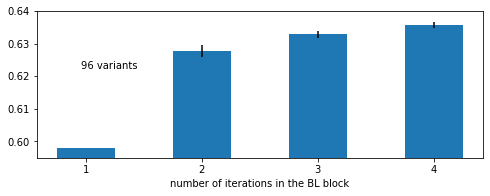

In [14]:
# this exactly match what's in basic_for_20200218_cc2normed.ipynb


# (48, 4)
# [1, 2, 3, 4]
# n 48
# 2 - 1 mean 0.029584268475115222 sem 0.0023691908064684014
# 3 - 2 mean 0.005058711595277207 sem 0.0011520950345487745
# 4 - 3 mean 0.002843366782809708 sem 0.0008682186522390155
# 4 - 2 mean 0.007902078378086916 sem 0.0013188904547508022


# they are exactly the same while one

plot_step_increase(df_all.xs(key=3, level='kernel_size_l23').xs(
    key='test', level='subset'
).xs(key='cc2_normed', level='measure')['val'], [(1,2),(2,3),(3,4),(2,4)], (0.595, 0.64))

(96, 4)
[1, 2, 3, 4]
n 96
2 - 1 mean -0.000875749832584392 sem 5.023901181055234e-05
3 - 2 mean -0.00015471463676130877 sem 3.0461592983173983e-05
4 - 3 mean -8.488210484790021e-05 sem 2.678937439547173e-05
4 - 2 mean -0.00023959674160920898 sem 3.312778497295013e-05


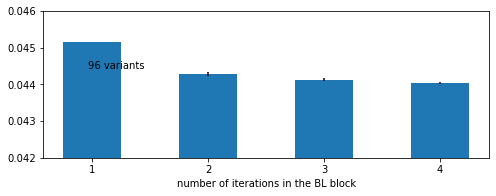

In [15]:
# good
plot_step_increase(
    df_all.xs(key=3, level='kernel_size_l23').xs(
        key='test', level='subset'
    ).xs(
        key='mse_normed', level='measure'
    )['val'],
    [(1,2),(2,3),(3,4),(2,4)],
    (0.042, 0.046)
)

(384, 4)
[1, 2, 3, 4]
n 384
2 - 1 mean -0.0008849500326724953 sem 2.8709855430180002e-05
3 - 2 mean -0.00013282937613884904 sem 1.638433569383591e-05
4 - 3 mean -1.820565955557467e-05 sem 1.500478062289092e-05
4 - 2 mean -0.00015103503569442373 sem 1.848807846958609e-05


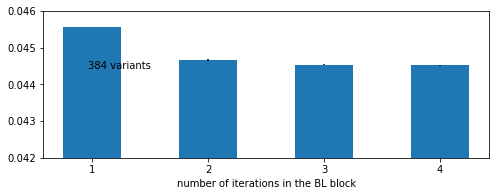

In [16]:
plot_step_increase(
    df_all.xs(
        key='test', level='subset'
    ).xs(
        key='mse_normed', level='measure'
    )['val'],
    [(1,2),(2,3),(3,4),(2,4)],
    (0.042, 0.046)
)

(96, 4)
[1, 2, 3, 4]
n 96
2 - 1 mean -0.0018810686224730352 sem 0.00011085701285520217
3 - 2 mean -0.0003477266984786183 sem 6.602624019883166e-05
4 - 3 mean -0.00018347688544928563 sem 5.578203845594446e-05
4 - 2 mean -0.0005312035839279039 sem 7.307161140836516e-05


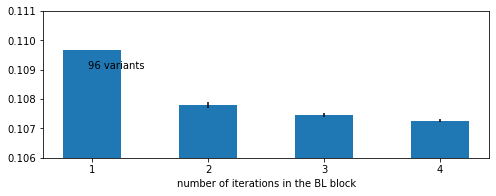

In [17]:
# good
plot_step_increase(
    df_all.xs(key=3, level='kernel_size_l23').xs(
        key='test', level='subset'
    ).xs(
        key='mse', level='measure'
    )['val'],
    [(1,2),(2,3),(3,4),(2,4)],
    (0.106, 0.111)
)

(384, 4)
[1, 2, 3, 4]
n 384
2 - 1 mean -0.001929832852825438 sem 6.268362597837845e-05
3 - 2 mean -0.00030453311867603293 sem 3.635117540879588e-05
4 - 3 mean -5.897279281330258e-05 sem 3.249862684806291e-05
4 - 2 mean -0.0003635059114893355 sem 4.0417145224322466e-05


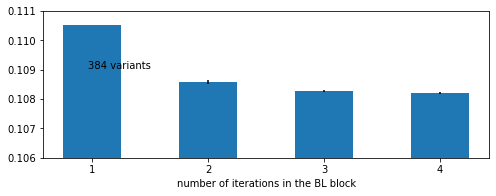

In [18]:
plot_step_increase(
    df_all.xs(
        key='test', level='subset'
    ).xs(
        key='mse', level='measure'
    )['val'],
    [(1,2),(2,3),(3,4),(2,4)],
    (0.106, 0.111)
)